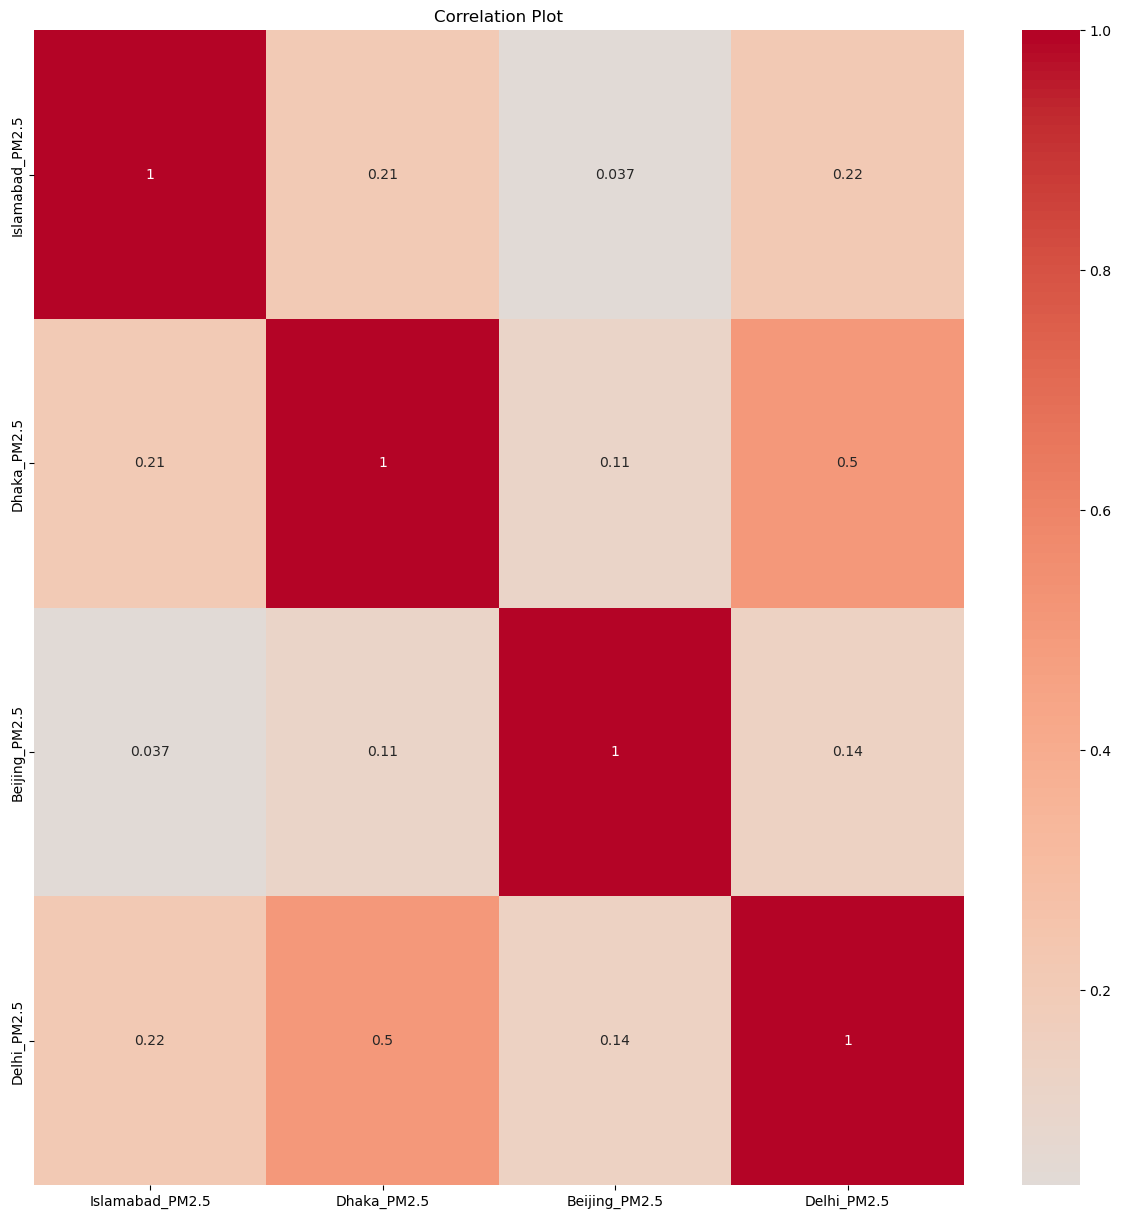

features: (32517, 4)
targets: (32517, 1)
X_train: (23493, 4)
X_test: (4878, 4)
X_val: (4146, 4)
y_train: (23493, 1)
y_test: (4878, 1)
y_val: (4146, 1)


ValueError: A merge layer should be called on a list of inputs. Received: input_shape=(None, 10, 32) (not a list of shapes)

In [10]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
df = pd.read_csv(r'D:\A_NAUSHAD\E\Dataset\Book7.csv',
                 parse_dates=['Date'],
                 index_col=['Date'])


correlation_matrix = df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Plot')
plt.show()

dataset = df.copy()
dataset


for a in range(len(df.columns)):
    b=df.iloc[:,a:a+1]
    features=df.values   # df.values  b.values for sigle 
    targets=b.values

    X_train, X_test, y_train, y_test  = train_test_split(features, targets, test_size=0.15, random_state=1, shuffle=False)

    X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.15, random_state=1, shuffle=False)

    print("features:", features.shape)
    print("targets:", targets.shape)

    print("X_train:", X_train.shape)
    print("X_test:", X_test.shape)
    print("X_val:", X_val.shape)

    print("y_train:", y_train.shape)
    print("y_test:", y_test.shape)
    print("y_val:", y_val.shape)
    

    scaler = MinMaxScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)

    X_val = scaler.transform(X_val)

    X_test = scaler.transform(X_test)

    X_train.shape, X_test.shape


    win_length=10
    batch_size=9
    num_features=features.shape[1]

    train_generator = TimeseriesGenerator(X_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
    val_generator = TimeseriesGenerator(X_val, y_val, length=win_length, sampling_rate=1, batch_size=batch_size)
    test_generator = TimeseriesGenerator(X_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)
    
    model_CNNLSTM = tf.keras.Sequential([
    # First WaveNet layer
    tf.keras.layers.Conv1D(filters=32, kernel_size=2, dilation_rate=2, padding='causal', input_shape=(win_length, num_features)),
    tf.keras.layers.Activation('tanh'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=2, dilation_rate=2, padding='causal'),
    tf.keras.layers.Activation('sigmoid'),
    tf.keras.layers.Multiply(),
    
    # Second WaveNet layer
    tf.keras.layers.Conv1D(filters=32, kernel_size=2, dilation_rate=4, padding='causal'),
    tf.keras.layers.Activation('tanh'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=2, dilation_rate=4, padding='causal'),
    tf.keras.layers.Activation('sigmoid'),
    tf.keras.layers.Multiply(),
    
    # Third WaveNet layer
    tf.keras.layers.Conv1D(filters=32, kernel_size=2, dilation_rate=8, padding='causal'),
    tf.keras.layers.Activation('tanh'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=2, dilation_rate=8, padding='causal'),
    tf.keras.layers.Activation('sigmoid'),
    tf.keras.layers.Multiply(),
    
    # Bidirectional LSTM layers
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='tanh', return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='tanh', return_sequences=False)),
    
    # Dropout for regularization
    tf.keras.layers.Dropout(0.1),
    
    # Final dense layer
    tf.keras.layers.Dense(1)
    ])


    model_CNNLSTM.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.01),loss=tf.losses.MeanSquaredLogarithmicError())

    tf.keras.utils.plot_model(model=model_CNNLSTM, show_shapes=True)
    

    lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, cooldown=1)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

    with tf.device('/GPU:0'):
        prepared_model_CNNLSTM = model_CNNLSTM.fit(train_generator, 
                                           validation_data=val_generator,
                                           epochs=2, 
                                           shuffle=False,  
                                           callbacks=[lr_monitor, early_stopping])
        
    plt.plot(prepared_model_CNNLSTM.history["loss"],label="loss")
    plt.plot(prepared_model_CNNLSTM.history["val_loss"],label="val_loss")
    plt.legend(loc="best")
    plt.xlabel("No. Of Epochs")
    plt.ylabel("mse score")
    
    
    # Create a DataFrame for August with hourly timestamps
    august_dates = pd.date_range(start='2023-01-29', end='2025-12-31', freq='H')
    df_august = pd.DataFrame(index=august_dates)

    # Forecast PM2.5 and Temp values for August using the model
    august_generator = TimeseriesGenerator(features, np.zeros(len(features)), length=win_length, sampling_rate=1, batch_size=1)
    predicted_values_august = model_CNNLSTM.predict(august_generator)
    #predicted_values_august = (predicted_values_august * pm25_std) + pm25_mean

    # Ensure the length of forecasted values matches the length of the DataFrame index for August
    df_august['PM2.5'] = predicted_values_august[:len(df_august)]

    f=df_august['PM2.5']

    
        # downloading csv file
    cities = pd.DataFrame(f)
    cities.to_csv('D:/A_NAUSHAD/E/RESULTS/FORE/train_RNN_'+df.iloc[:,a:a+1].columns[0]+'_S_fore.csv')


    # Plot the forecasted PM2.5 values for August
    plt.figure(figsize=(12, 6))
    plt.plot(df_august.index, df_august['PM2.5'], label='Forecasted PM2.5')
    plt.xlabel('Hour')
    plt.ylabel('PM2.5')
    plt.legend()
    plt.title('One-Year Forecast of Hourly PM2.5 for August')
    plt.show()

    
    # downloading csv file
    cities = pd.DataFrame(prepared_model_CNNLSTM.history["loss"])
    cities.to_csv('D:/A_NAUSHAD/E/RESULTS/LOSS/train_RNN_'+df.iloc[:,a:a+1].columns[0]+'_S_loss.csv')

    # downloading csv file
    cities = pd.DataFrame(prepared_model_CNNLSTM.history["val_loss"])
    cities.to_csv('D:/A_NAUSHAD/E/RESULTS/LOSS/val_RNN_'+df.iloc[:,a:a+1].columns[0]+'_S_loss.csv')

    model_CNNLSTM.evaluate(train_generator, verbose=1)
    predictions=model_CNNLSTM.predict(train_generator)

    pd.DataFrame(predictions)

    # downloading csv file
    cities = pd.DataFrame(predictions)
    cities.to_csv('D:/A_NAUSHAD/E/RESULTS/PRED/train_RNN_'+df.iloc[:,a:a+1].columns[0]+'_S_pred.csv')

    model_CNNLSTM.evaluate(test_generator, verbose=1)

    predictions=model_CNNLSTM.predict(test_generator)

    pd.DataFrame(predictions)

    # downloading csv file
    cities = pd.DataFrame(predictions)
    cities.to_csv('D:/A_NAUSHAD/E/RESULTS/PRED/test_RNN_'+df.iloc[:,a:a+1].columns[0]+'_S_pred.csv')

    df_pred=pd.DataFrame(X_test[:,:][win_length:])

    rev_trans=scaler.inverse_transform(df_pred)

    df_final=dataset[rev_trans.shape[0]*-1:]

    df_final[[df.iloc[:,a:a+1].columns[0]+"_pred"]]=predictions

    df_final


    df_final[[df.iloc[:,a:a+1].columns[0],df.iloc[:,a:a+1].columns[0]+"_pred"]].plot(figsize=(20,10))

    def evaluate_preds(y_true, y_pred):
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)

        # Calculate various metrics
        mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
        mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
        rmse = tf.sqrt(mse)
        mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
        mslr = tf.keras.metrics.mean_squared_logarithmic_error(y_true, y_pred)

        return {"mae": mae.numpy(),
                "mse": mse.numpy(),
                "rmse": rmse.numpy(),
                "mape": mape.numpy(),
                "mslr": mslr.numpy(),
               }


    selected_features = [df.iloc[:,a:a+1].columns[0]]

    for feature in selected_features:
        print("-----{}-----".format(feature))
#         evala=evaluate_preds(y_true=df_final[feature].values,
#                              y_pred=df_final["{}_pred".format(feature)].values)
#         print(evala)
#         eval=pd.DataFrame.from_dict(evala,index=[0] )
#         eval.to_csv(df.iloc[:,a:a+1].columns[0]+"_evaluation.csv")
        eval_results = evaluate_preds(y_true=df_final[feature].values, y_pred=df_final["{}_pred".format(feature)].values)
        eval_df = pd.DataFrame.from_dict(eval_results, orient='index', columns=['value'])
        eval_df.to_csv('D:/A_NAUSHAD/E/RESULTS/EVAL\{}_RNN_evaluation_S.csv'.format(df.iloc[:, a:a+1].columns[0]))
